<center>
<h1> Modelo de predicción</h1>
<h2> El caso del Titanic</h2>
</center>

Construcción de un arbol de decisión para conocer si un pasajero del Titanic sobrevive al incidente.

In [111]:
# Librerias para analizar los datos
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Modelos predictivos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Matriz de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Curva ROC
from sklearn.metrics import roc_curve

# Fijamos algunos parámetros de las gráficas
plt.style.use(style= "seaborn-paper")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 140

In [112]:
# Importando los datos
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [113]:
print(train.shape)
print(train.info())

# Descripción general de las variables numéricas
train.describe()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [114]:
# Descripción general de las variables categoricas
train.describe(include= ["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Exploración general de los datos

Lo primero que haremos será determinar si existe algún tipo de relación entre las variables que pueda indicarnos si alguna característica de los pasajeros determina si este subrevive o no al incidente.

Como punto de partida observamos cuántos pasajeros lograron sobrevivir.

In [115]:
# Cantidad de pasajeros que sobrevivieron
print(train.groupby("Survived").count()["PassengerId"])

# Porcentaje de sobrevivientes
print(f"En la muestra del Titanic el porcentaje de sobrevivientes fue {(342/891)*100:.2f}%")

Survived
0    549
1    342
Name: PassengerId, dtype: int64
En la muestra del Titanic el porcentaje de sobrevivientes fue 38.38%


De lo anterior podemos notar que solo el 38.38% de los pasajeros en nuestra muestra sobrevivieron. A partir de esto es que comenzaremos a explorar las possbiles relaciones entre la variable **'Survived'** y el resto de varibles.

## Relación entre la posibilidad de sobrevivir y el sexo del pasajero
Dentro de un accidente como el Titanic uno podría preguntarse si el sexo fue un factor determinante para que un pasajero sobreviviera. Es muy probable que los hombres cedieran los barcos de emergencia a las mujeres y niños para que escaparan, esto sucedería con mayor frecuencia para aquellos que viajaran con sus familias. Es por ello que se indaga sobre la relación existente entre el sexo y la posibilidad de sobrevivir.

Text(0.5, 0, 'Sobrevivió')

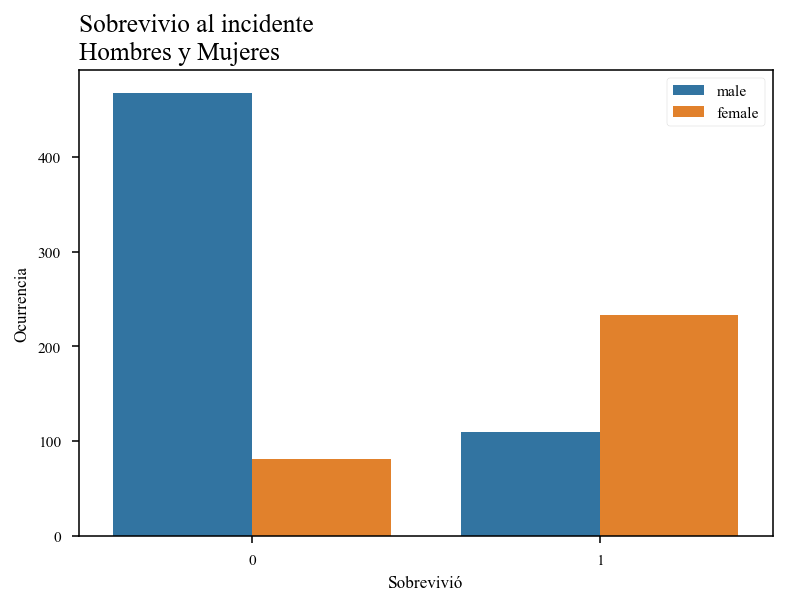

In [116]:
sns.countplot(data = train, x = "Survived", hue = "Sex")
plt.legend()

plt.title("Sobrevivio al incidente \nHombres y Mujeres", loc = "left", fontsize = 13)
plt.ylabel("Ocurrencia")
plt.xlabel("Sobrevivió")

Vemos que existe una característica que salta a la vista y es que la mayoría de hombres en el titanic no sobrevivió mientras que la mayoría de mujeres si los hicieron. Cabe preguntarse ¿Todos los hombres tenían las mismas probabilidades? ¿En el caso de las mujeres sucedia lo mismo? ¿Dependía la posibilidad de sobrevivir de alguna otra variable? Para responder a lo anterior incorporaremos otra varaible y es la clase en la que viajaban los pasajeros.

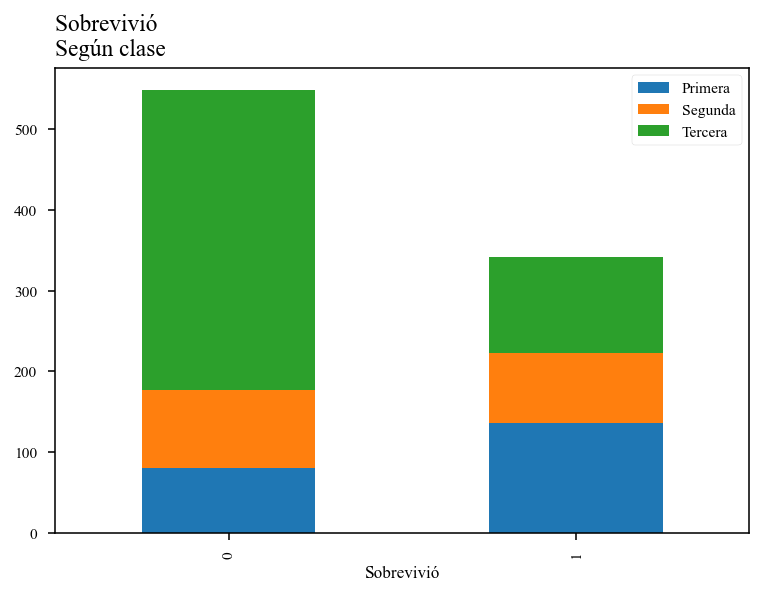

In [117]:
train.groupby(["Survived", "Pclass"]).count()["PassengerId"].unstack().plot(kind= "bar", stacked= True)
plt.legend(["Primera", "Segunda", "Tercera"])
plt.xlabel("Sobrevivió")

plt.title("Sobrevivió \nSegún clase", fontsize = 12, loc = "left")

plt.show()

La clase en la que viajaban los pasajeros es otra variable que guarda relación con la posibilidad de sobrevivir. Vemos que la mayoría de las personas que viajaban en primera clase sobrevivieron mientras que los que viajaban en tercera no lo hicieron. Con relación a la segunda clase la relación parece no ser tan evidente aúnque se puede decir que con una mínima diferencia la mayor parte murió.

Esto lo podemos notar en la siguiente tabla que muestra el porcentaje de sobrevivientes dependiendo de la clase en la que viajaban.

In [118]:
train.groupby(["Survived", "Pclass"]).count()["PassengerId"].unstack(level= 0).assign(porcentaje = lambda x: (x[1]/(x[0]+ x[1])*100))

Survived,0,1,porcentaje
Pclass,,,
1,80,136,62.962963
2,97,87,47.282609
3,372,119,24.236253


Se introduce la siguiente gráfica que muestra si un pasajero sobrevivió o no dependiendo de si es hombre o mujer y la clase en la que viajaba. El gráfico es revelador en varios aspectos.

1. Independientemente de clase en la que se viabaja la mayoría de hombres murieron.
2. La primera clase presentó el mayor número de sobrevivientes hombres. En este aspecto la segunda y tercera clase se queda muy rezagados.
3. La mayoría de las mujeres de primera y segunda clase sobrevivieron mientras que las mujeres de tercera clase murieron en igual proporción de las que sobrevivieron.

La relación es concluyente, el sexo y clase en la que se viajaba son factores determinantes en la posibilidad de sobrevivir en el Titanic.

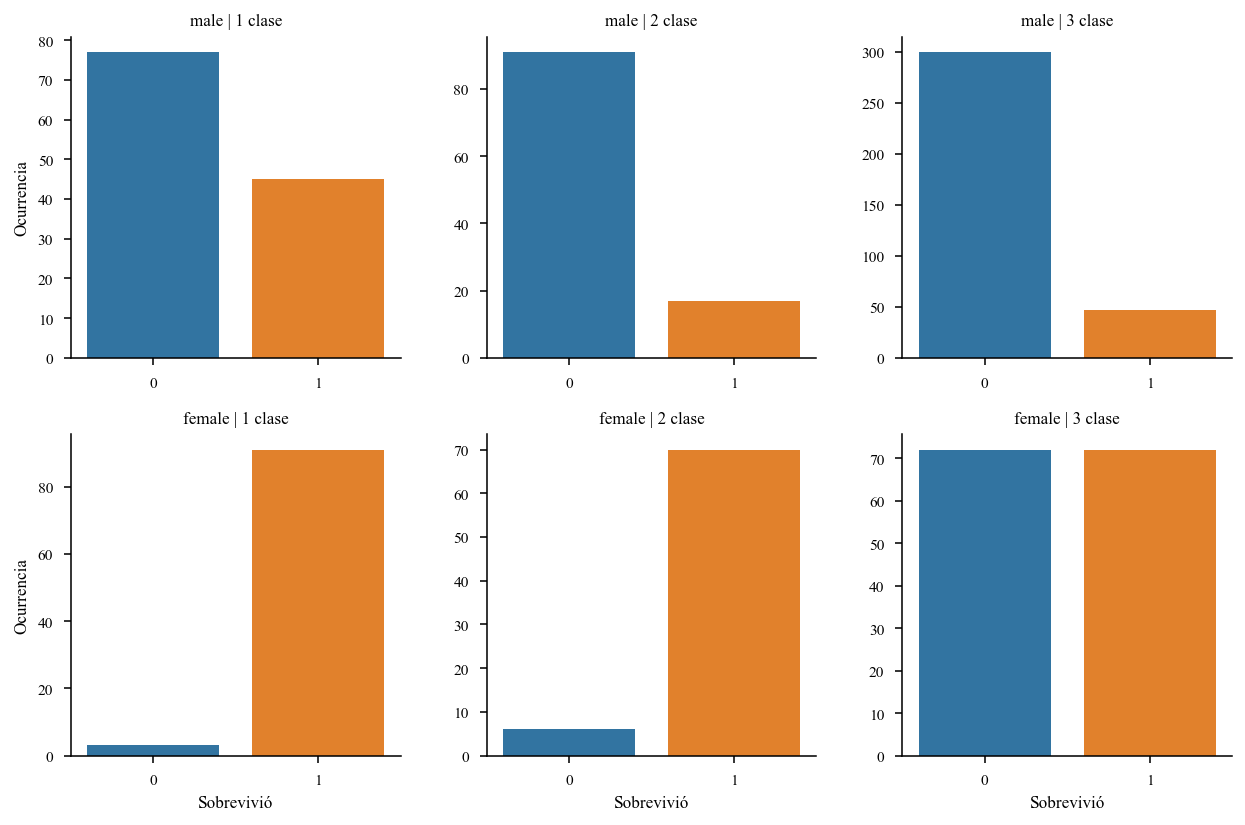

In [119]:
(sns.FacetGrid(data = train, sharey= False, sharex = False, col = "Pclass", row = "Sex")
.map_dataframe(sns.countplot, x = "Survived", palette = "tab10")
.set_ylabels("Ocurrencia")
.set_xlabels("Sobrevivió")
.set_titles(col_template = "{col_name} clase", row_template = "{row_name}"))

plt.show()

Ahora indagaremos respecto a si viajar acompñado tendría alguna incidencia en la posbilidad de sobrevivir. Para ello crearemos una nueva variable que será 0 si se viajaba acompañado y 1 si se viajaba solo.

In [120]:
train["acompañado"] = np.where((train["SibSp"] == 0) & (train["Parch"] == 0), 1, 0)

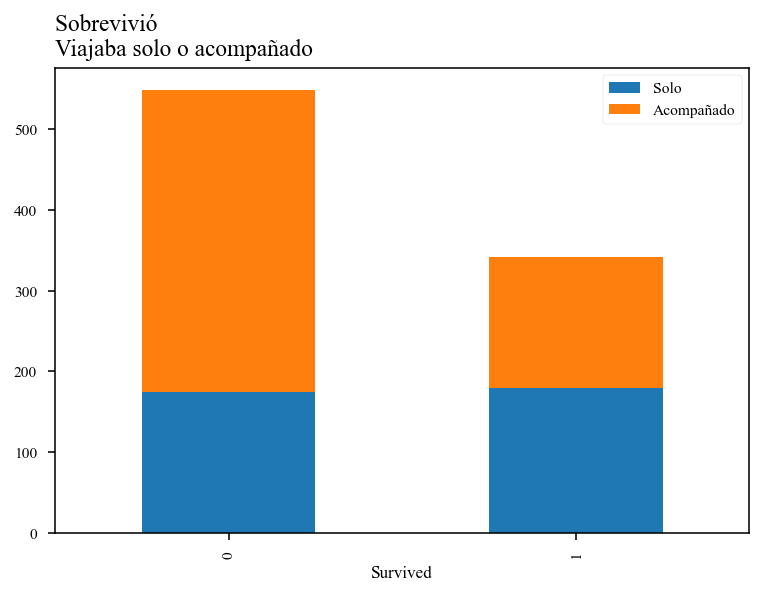

In [121]:
train.groupby(["Survived", "acompañado"]).count()["PassengerId"].unstack().plot(kind= "bar", stacked= True)

plt.legend(["Solo", "Acompañado"])
plt.title("Sobrevivió \nViajaba solo o acompañado", fontsize = 12, loc = "left")

plt.show()

Lo que podemos observar es que las personas que viajas solas tienen una mayor predisposición a morir a diferencia de los que están acompañados.

Por úlitmo observaremos cómo se comporta esta característica dependiendo del sexo.

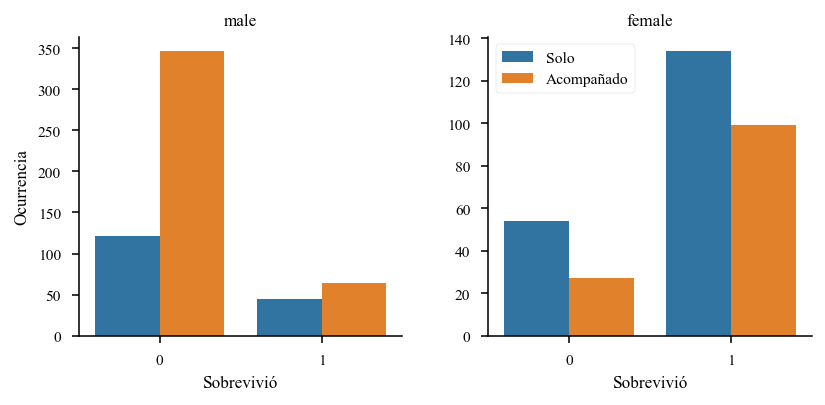

In [122]:
(sns.FacetGrid(data = train, col= "Sex", sharey= False)
.map_dataframe(sns.countplot, x = "Survived", hue = "acompañado", palette = "tab10")
.set_titles(col_template = "{col_name}")
.set_xlabels("Sobrevivió")
.set_ylabels("Ocurrencia"))

plt.legend(["Solo", "Acompañado"])
plt.show()


Los hombres que viajaban solos son los que reportan el menor número de muertos mientras que para el caso de las mujeres, si estas se encontraban acompañas, aumentaban su posibilidad de sobrevivir.

Lo anterior confirma que el sexo vuelve a ser una variable determinante en la posibilidad de sobrevivir y muestra como la condición de viajar solo también puede ser una característica relevante.

### Relación entre la edad y sus posibilidades de sobrevivir

Finalmente se busca establecer alguna relación entre la edad y la posibilidad de sobrevivir. Vemos que la mayoría de las personas que sobrevivieron al incidente fueron personas comprendidas en las edades de 20 y 30 años y en una proporción menor los niños.

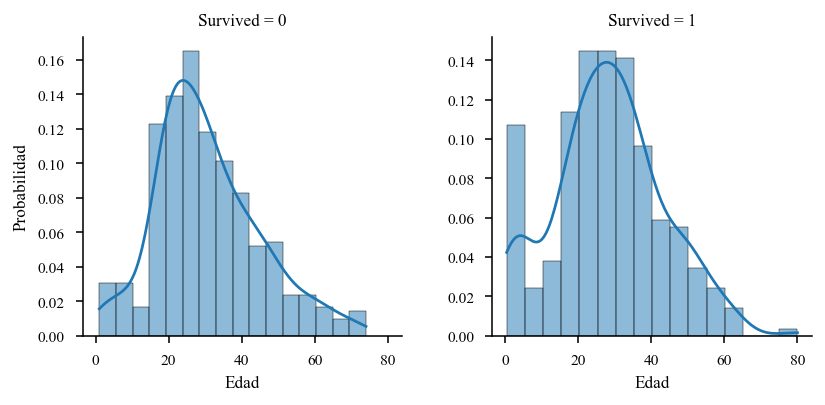

In [123]:
(sns.FacetGrid(data = train, sharey =  False, col = "Survived")
.map_dataframe(sns.histplot, x = "Age", kde = True, stat = "probability")
.set_xlabels("Edad")
.set_ylabels("Probabilidad"))

plt.show()

## Construcción del modelo
A partir de la exploración anterior se construirá el modelo de predicción con un arbol de decisión considerando las siguientes varaibles:

1. Sexo
2. Clase en la que viajaba
3. La edad
4. Si el pasajero viajaba acompañado

El uso de este tipo de modelos posee una gran ventaja frente a la regresión logísta debido a que no asume ninguna forma funcional de partida, por el contrario, busca patrones para ajustarse de mejor manera a los datos.

Dentro de la construcción del modelo se hace necesario hacer un tratamiento previo de los datos debido a que la variable edad cuenta con valores faltantes y el sexo está dado como un string. Dicho tratamiento comenzará imputando la edad a los pasajeros que no la reportaron.

### Imputando la edad

Lo primero que debemos hacer es conocer la distribución distribución de la edad para ambos sexos. Estos importante ya que nos permite conocer si la imputación se realizará con la media o mediana en dado caso los datos no se distribuyan de forma normal.

Jarque Bera para la edad de mujeres
(3.1354963141651506, 0.2085141953009644, 0.20491020536515253, 2.653058029200903)
------------------------------------------------------------------------------------
Jarque Bera para la edad de hombres
(19.112970436967167, 7.074100138154304e-05, 0.47374277465489795, 3.3389378101051843)


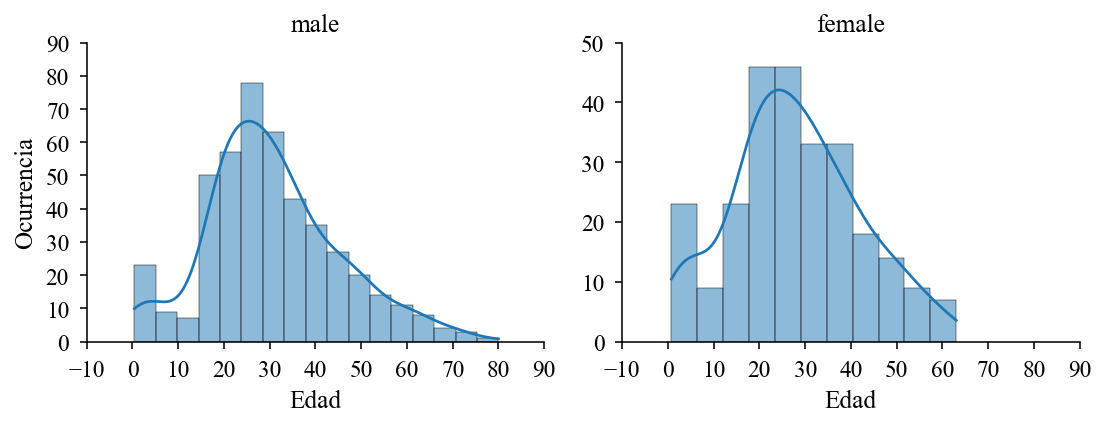

In [124]:
# Estadístico para confirmar si la edad se distribuye de forma normal
from statsmodels.stats.stattools import jarque_bera
print("Jarque Bera para la edad de mujeres")
print(jarque_bera(train.query("Sex == 'female'")["Age"].dropna()))

print("------------------------------------------------------------------------------------")
print("Jarque Bera para la edad de hombres")
print(jarque_bera(train.query("Sex == 'male'")["Age"].dropna()))

# Gráfica
g = sns.FacetGrid(train, col = "Sex", sharey= False, aspect = 1.3)
g = g.map_dataframe(sns.histplot, x = "Age", kde = True)
g.set_ylabels("Ocurrencia", size = 13)
g.set_xlabels("Edad", size = 13)
g.set_titles(col_template = "{col_name}", size = 13)
g.set_xticklabels(size = 12)
g.set_yticklabels(size = 12)
del(g)

Dado que la distribución de la edad para el caso de las mujeres se distribuye de forma normal según el test de jarque bera y para los hombres no, la imputación se hará con la media para las mujeres y con la mediana para los hombres.

In [125]:
# Imputando la edad según el sexo y la clase en la que se encuentra
train["Age"] = train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Transformar la variable **Sex** en binaria

Por último vamos a transformar la variable sex en binaria para que poder estimar el modelo.

In [126]:
train["Sex"] = train["Sex"].map({"male": 0, "female": 1}).astype(int)

## Separar la muestra en prueba y testeo

Se separa el conjunto de datos a fin de tener un conjunto de entrenamiento y un conjunto de prueba para conocer la forma en la que está trabajando el modelo.

In [127]:
from sklearn.model_selection import train_test_split

y = train["Survived"]
x = train[["Sex", "Pclass", "Age", "acompañado"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 1)

## Modelos de predicción

Para realizar la predicción se hará uso de dos modelos, el primero será una regresión logística y el segundo un modelo de árbol de decisión y se comparan sus resultados a partir del acierto que tuvieron y la curva ROC de cada uno.

### Modelo de regresión logística

In [128]:
# ajustando el modelo
logistico = LogisticRegression().fit(X = x_train, y = y_train)

# obteniendo predicciones
y_pred_logi = logistico.predict(x_test)

Acierto logistico 0.7798507462686567


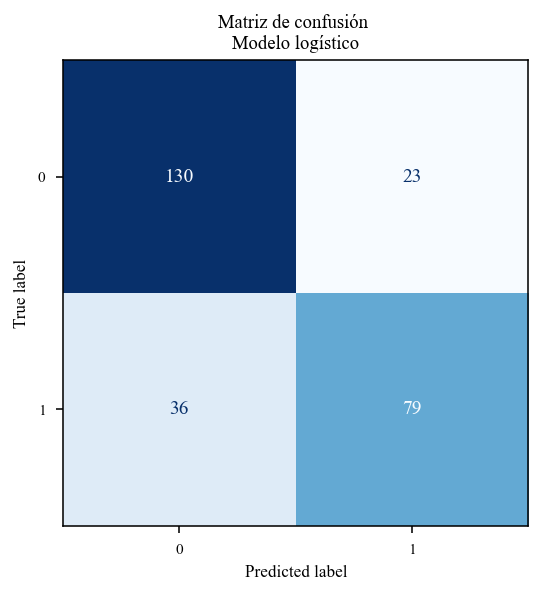

In [129]:
# Matriz de confusión
print(f"Acierto logistico {accuracy_score(y_true = y_test, y_pred= y_pred_logi)}")

cm_logi = confusion_matrix(y_true= y_test, y_pred= y_pred_logi)
a = ConfusionMatrixDisplay(cm_logi).plot(cmap = "Blues", colorbar= False)
plt.title("Matriz de confusión \nModelo logístico")

plt.show()

### Modelo de arbol de decisión


In [130]:
# Modelo
arbol = DecisionTreeClassifier(criterion= "entropy")
arbol = arbol.fit(x_train, y_train)

# Predicción
y_pred_arbol = arbol.predict(x_test)

Acierto arbol de desición 0.7649253731343284


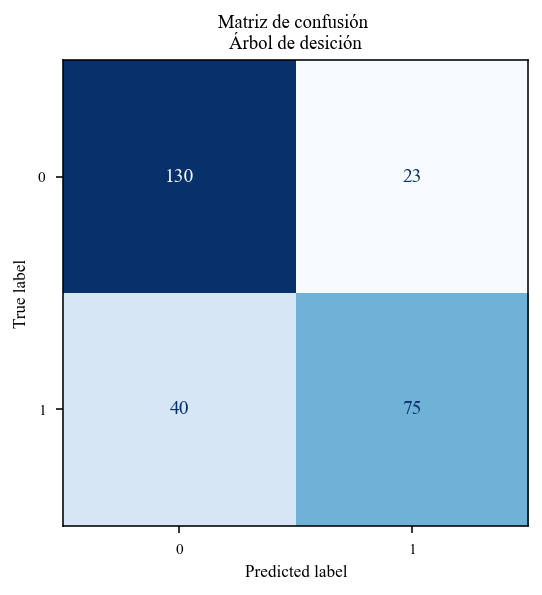

In [131]:
# Matriz de confisión para corroborar
cm_arbol = confusion_matrix(y_test, y_pred_arbol)

print("Acierto arbol de desición", accuracy_score(y_test, y_pred_arbol))
b = ConfusionMatrixDisplay(cm_arbol).plot(cmap = "Blues", colorbar = False)
plt.title("Matriz de confusión \nÁrbol de desición")

plt.show()

### Gráfico de árbol de decisión

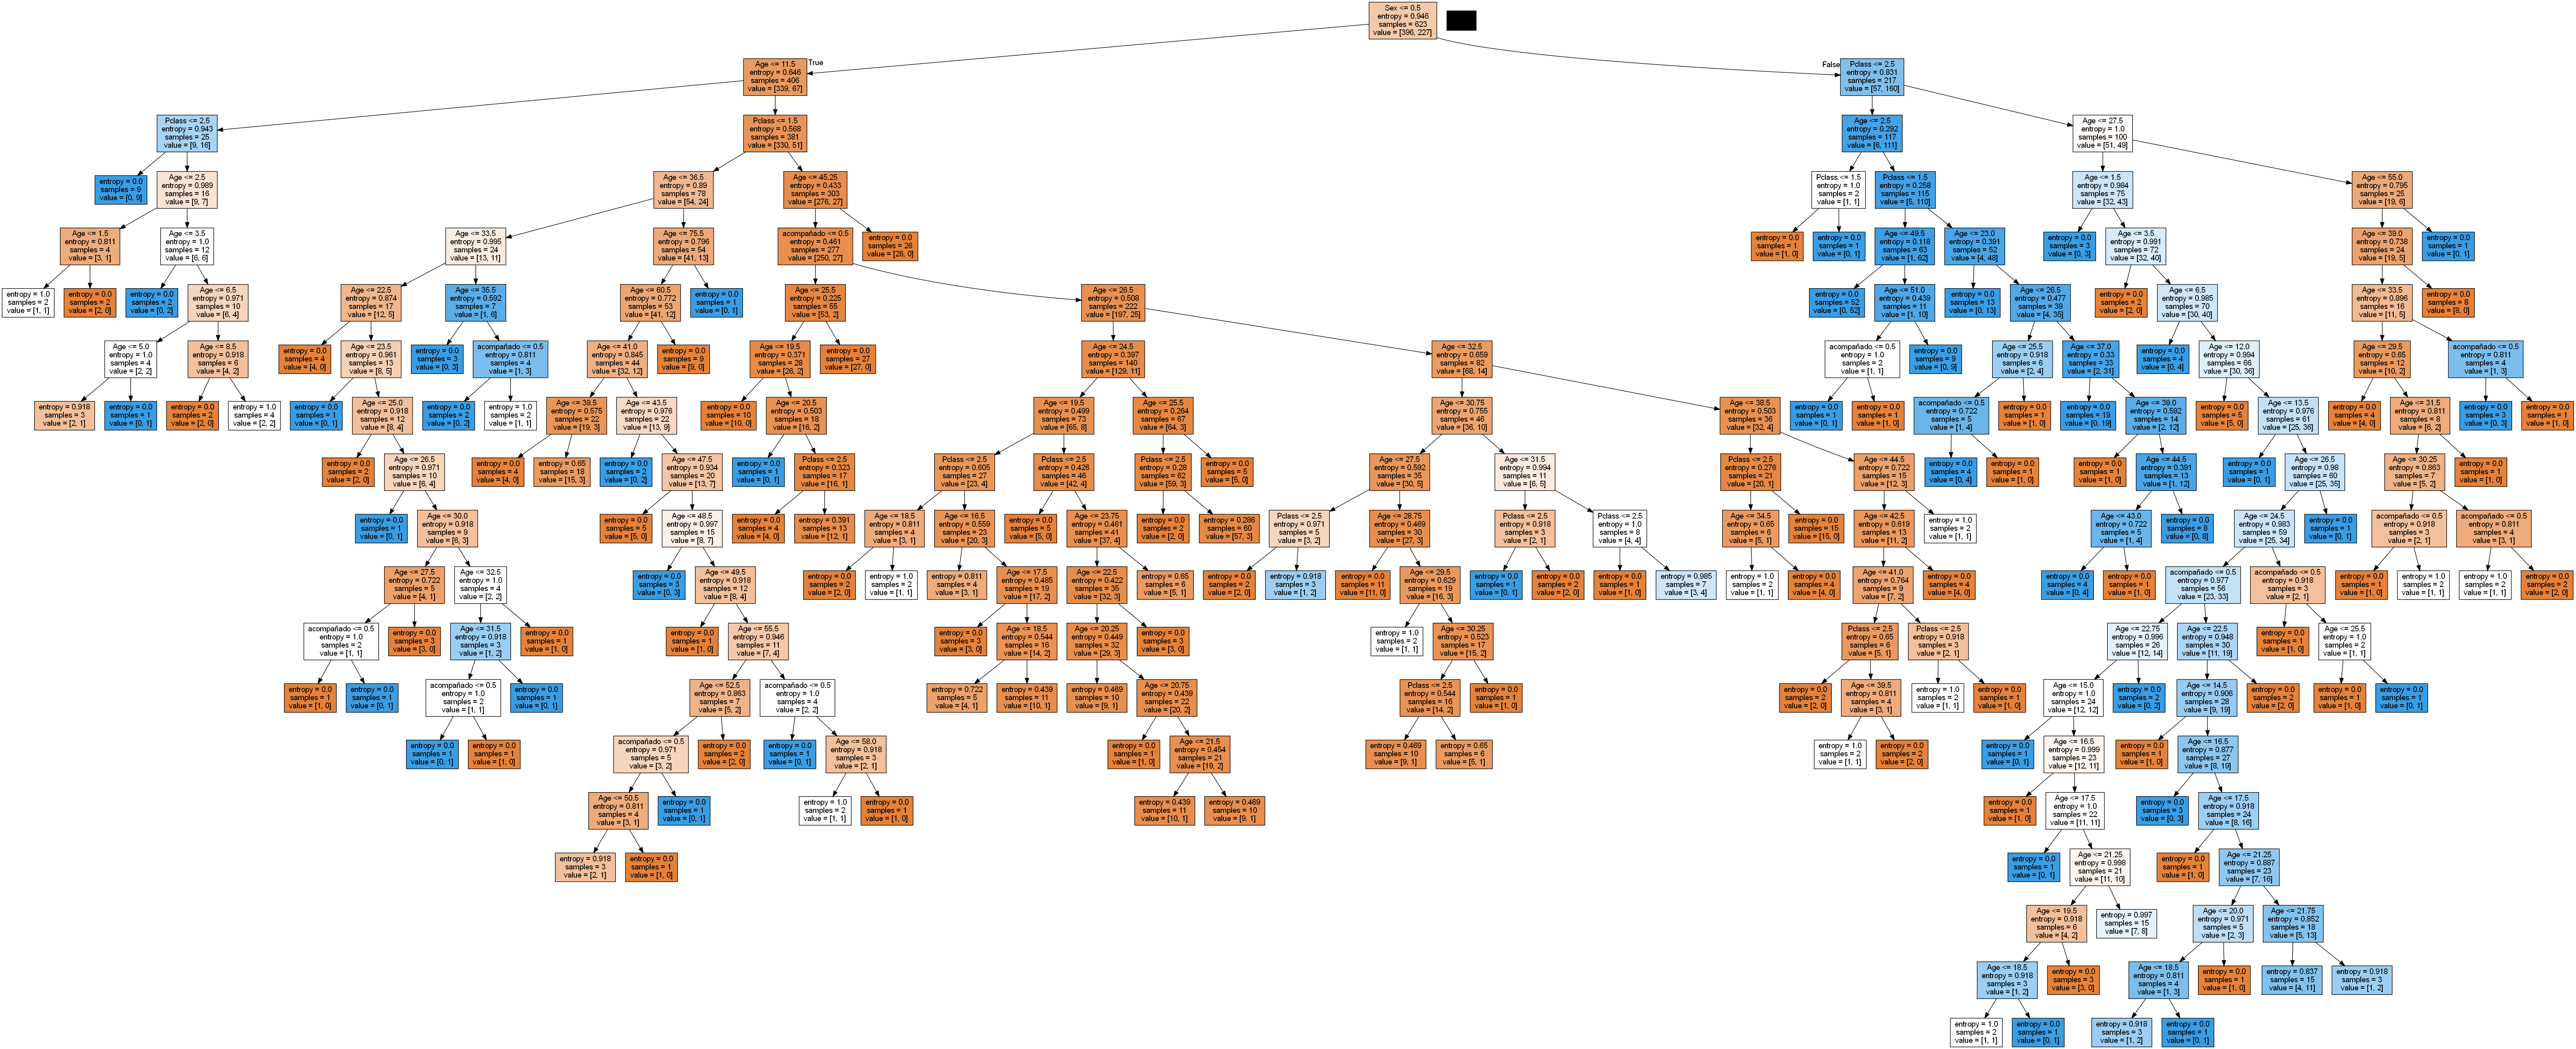

In [132]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

dot_data = export_graphviz(arbol,
                            feature_names= ["Sex", "Pclass", "Age", "acompañado"], filled= True)

graph = graph_from_dot_data(dot_data)
graph.write_png("árbol.png")
Image(graph.create_png())

## Comparativa modelos

In [133]:
print(f"El acierto del modelo logístico fue de {accuracy_score(y_true = y_test, y_pred = y_pred_logi)}")
print("-----"*30)
print(f"El acierto del modelo logístico fue de {accuracy_score(y_true = y_test, y_pred = y_pred_arbol)}")
print("-----"*30)
print("El modelo que mejor predijo fue el de tipo logístico")

El acierto del modelo logístico fue de 0.7798507462686567
------------------------------------------------------------------------------------------------------------------------------------------------------
El acierto del modelo logístico fue de 0.7649253731343284
------------------------------------------------------------------------------------------------------------------------------------------------------
El modelo que mejor predijo fue el de tipo logístico


# Curva ROC

In [134]:
# Curva ROC modelo logistico

score_logi = logistico.predict_proba(x_test)[:,1]

fpr_logi, tpr_logi, tresholds_logi = roc_curve(y_true = y_test, y_score = score_logi)


In [135]:
# Curva ROC árbol

score_arbol = arbol.predict_proba(x_test)[:,1]

fpr_arbol, tpr_arbol, tresholds_arbol = roc_curve(y_true = y_test, y_score = score_arbol)

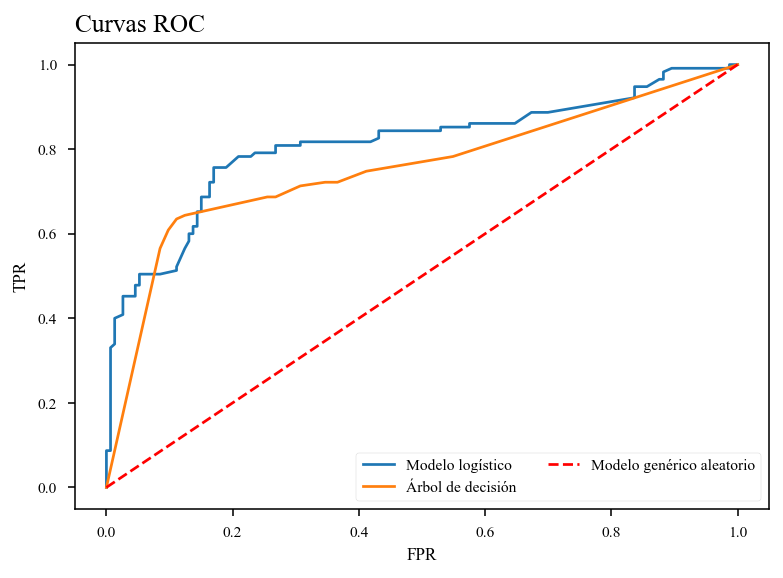

In [136]:
# Gráfica curva ROC

plt.plot(fpr_logi, tpr_logi, label = "Modelo logístico")
plt.plot(fpr_arbol, tpr_arbol, label = "Árbol de decisión")
plt.plot([0,1], [0,1], "r--", label = "Modelo genérico aleatorio")

plt.title("Curvas ROC", fontsize = 13, loc = "left")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc = "lower right", ncol =2)

plt.show()

Las curvas ROC muestran que el modelo con mejor predicción es el logístico pero se hará una simulación con 250 muestras aleatorias para tener mayor evidencia de que este resultado no es producto de la casualidad.

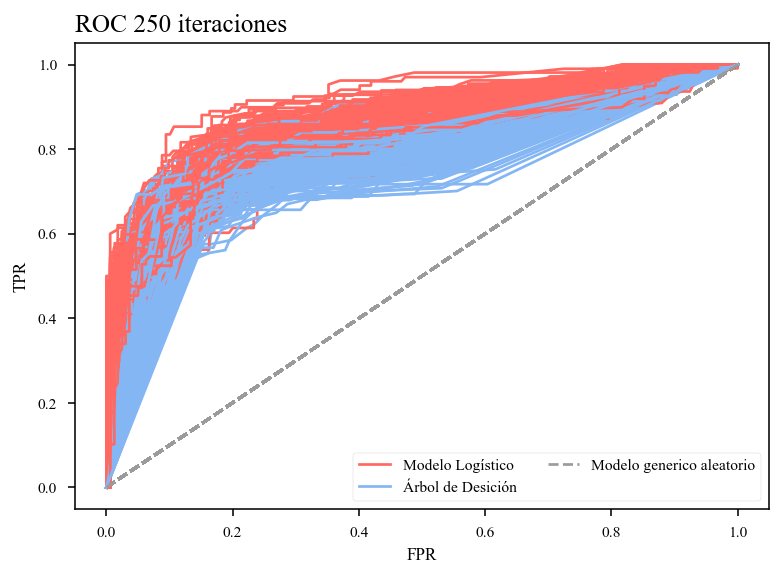

In [137]:
# Simulación con 5 muestreos aletorios

for i in range(250):
    x_loop = train[["Sex", "Pclass", "Age", "acompañado"]]
    y_loop = train["Survived"]

    x_train_loop, x_test_loop, y_train_loop, y_test_loop = train_test_split(x_loop, y_loop, test_size= 0.3)

    logistico = LogisticRegression().fit(X = x_train_loop, y = y_train_loop)
    arbol = DecisionTreeClassifier().fit(X = x_train_loop, y = y_train_loop)

    score_logi_loop = logistico.predict_proba(x_test_loop)[:,1]
    score_arbol_loop = arbol.predict_proba(x_test_loop)[:,1]

    fpr_logi_loop, tpr_logi_loop, tresholds_logi_loop = roc_curve(y_true = y_test_loop, y_score = score_logi_loop)
    fpr_arbol_loop, tpr_arbol_loop, tresholds_arbol_loop = roc_curve(y_true = y_test_loop, y_score = score_arbol_loop)

    plt.plot(fpr_logi_loop, tpr_logi_loop, "#ff6961")
    plt.plot(fpr_arbol_loop, tpr_arbol_loop, "#84b6f4")
    plt.plot([0,1], [0,1], "#9b9b9b", linestyle = "--")

    plt.title("ROC 250 iteraciones", fontsize = 13, loc = "left")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(["Modelo Logístico", "Árbol de Desición", "Modelo generico aleatorio"] ,loc = "lower right", ncol = 2)
    

    

In [141]:
test["acompañado"] = test["acompañado"] = np.where((test["SibSp"] == 0) & (test["Parch"] == 0), 1, 0)
test["Sex"] = test["Sex"].map({"male": 0, "female": 1}).astype(int)

predic_logi = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": logistico.predict(test[["Sex", "Pclass", "Age", "acompañado"]])})

predic_logi.to_csv("Predic_logi.csv", index = False)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values